In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import re
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import gensim
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [7]:
data = pd.read_csv(r'data/data.csv')
print(data)
data.party.value_counts()

                 user                                              tweet  \
0      NikemaWilliams  I voted early with my family. Today is the las...   
1      NikemaWilliams  @chantellym @boddieforga @nakitahemingway @Ali...   
2      NikemaWilliams  @ADW_esq @MurphyAJC @GeorgiaDemocrat Words to ...   
3      NikemaWilliams  Really @MurphyAJC 🙄 welp, won’t be the 1st tim...   
4      NikemaWilliams  RT @BetsyforGeorgia: A very energized crowd in...   
...               ...                                                ...   
64642          djueat  @JackPosobiec Like looking into toilet before ...   
64643          djueat  Tired from Winning vs. Tired from Omicron – an...   
64644          djueat  Tired from Winning vs. Tired from Omicron – an...   
64645          djueat                 @jonvoight Great words. Thank you.   
64646          djueat                 @jonvoight Great words. Thank you.   

                  name         state  distr party  incumbent  votes  receipt  \
0      

DEM    35355
REP    29292
Name: party, dtype: int64

### Pre-processing

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['amp',
                'know',
                'say',
                'today',
                'start',
                'week',
                'want',
                'day',
                'talk',
                'new',
                'thank',
                'birthday',
                'wish',
                'happy',
                'el',
                'los',
                'la',
                'rt',
                'ive',
                'continue',
                'thanks',
                'th',
                'also',
                'town',
                'hall',
                'let',
                'us',
                'last',
                'proud',
                'join',
                'like',
                'congratulations',
                 'ago',
                 'year',
                 'great',
                 'need',
                 'time',
                 'people'
                ]

stopwords.extend(new_stopwords)

from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(new_stopwords)


In [9]:
from string import punctuation

import nltk
nltk.download('wordnet')

def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('📝 …', '', tweet)
    return tweet

def remove_stopword(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

data["processed"] = data["tweet"].apply(preprocess_tweet)
data["processed"] = data["processed"].apply(basic_clean)
data["processed"] = data["processed"].apply(remove_stopword)




[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Most common words

In [10]:
cnt = Counter()

for text in data["processed"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)

[('vote', 4344),
 ('support', 2790),
 ('right', 2532),
 ('congress', 2496),
 ('state', 2316),
 ('biden', 2178),
 ('house', 2082),
 ('meet', 2061),
 ('help', 1905),
 ('honor', 1866)]

### Sentiment analysis using WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


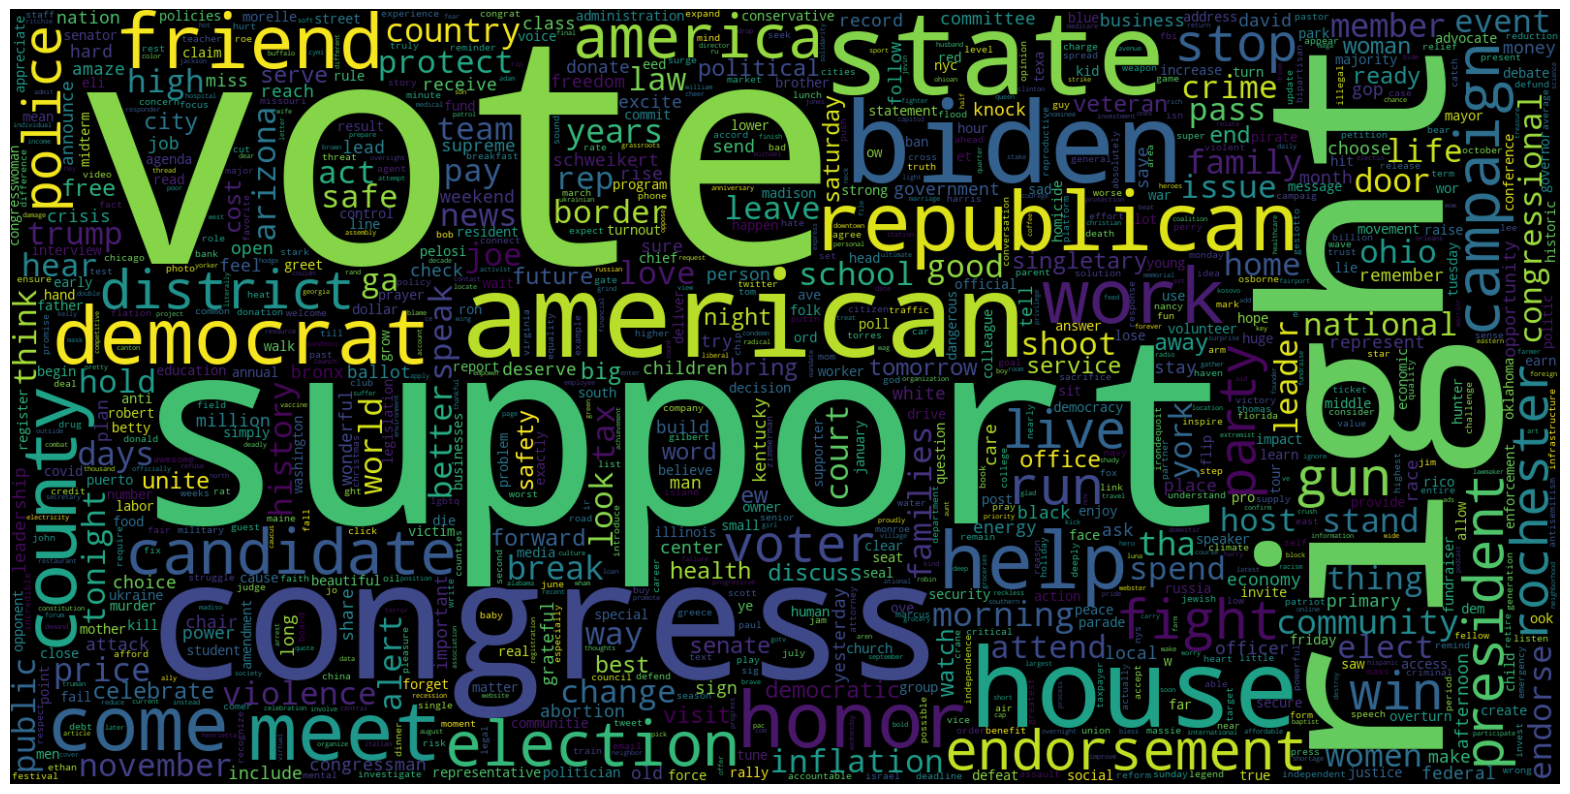

In [11]:
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")

text = " ".join(i for i in data.processed)
wordcloud = WordCloud(max_words=1000, width=1600, height = 800,
                      stopwords=stop_words, collocations = False).generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["processed"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["processed"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["processed"]]
data = data[["processed", "Positive", "Negative", "Neutral", "party"]]
print(data.head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                           processed  Positive  Negative  \
0                          vote early family georgia     0.000       0.0   
1                                      ook boyfriend     0.000       0.0   
2                                          word live     0.000       0.0   
3  welp win count pretty sure friends washington ...     0.756       0.0   
4  energize crowd college park cheer statewide de...     0.478       0.0   

   Neutral party  
0    1.000   DEM  
1    1.000   DEM  
2    1.000   DEM  
3    0.244   DEM  
4    0.522   DEM  


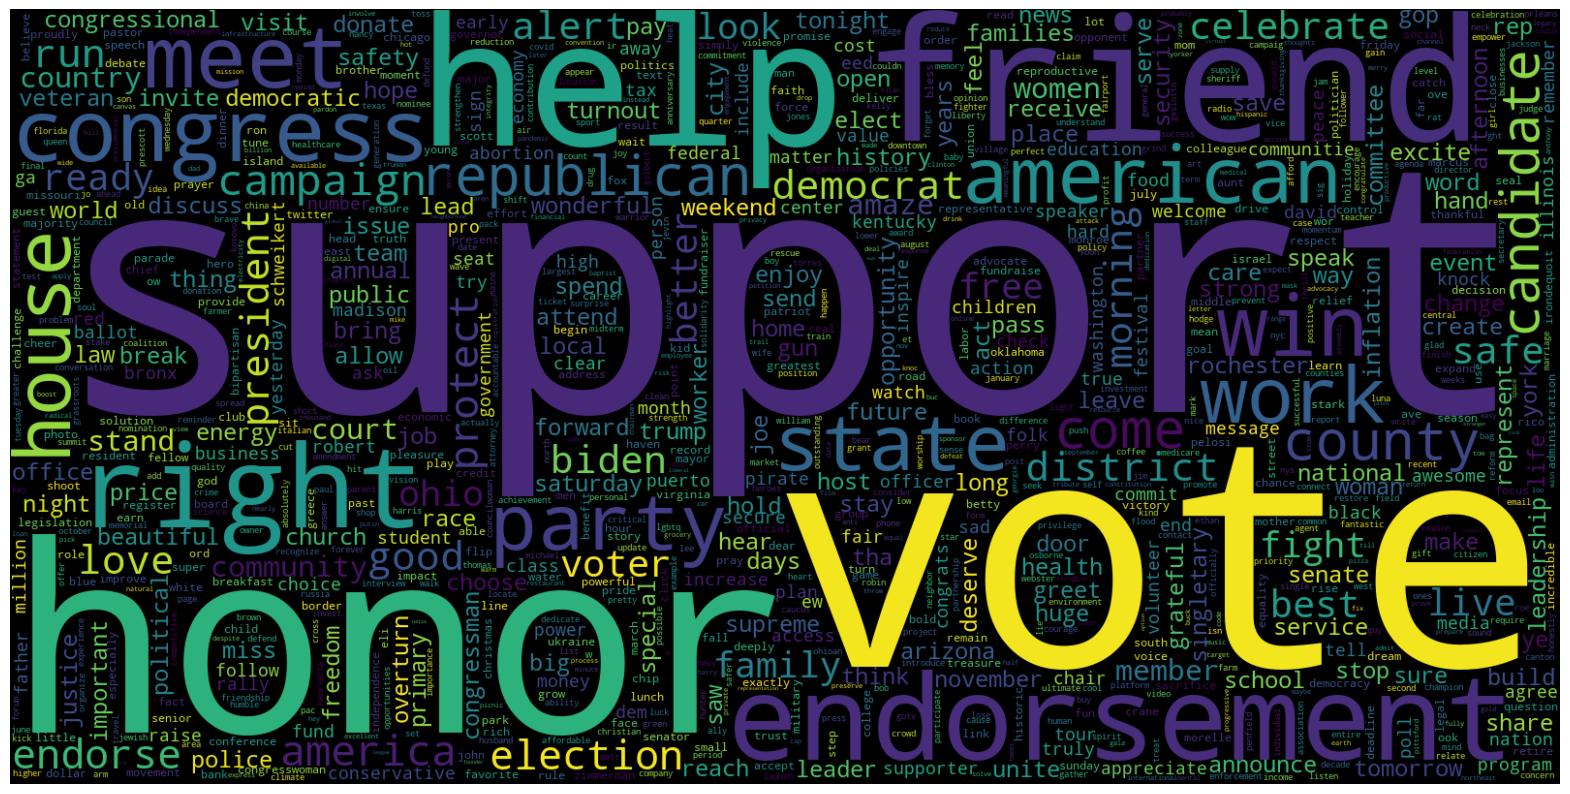

In [13]:
positive =' '.join([i for i in data['processed'][data['Positive'] > data["Negative"]]])
wordcloud = WordCloud(max_words=1000, width=1600, height = 800,
                      stopwords=stop_words, collocations = False).generate(positive)
plt.figure( figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

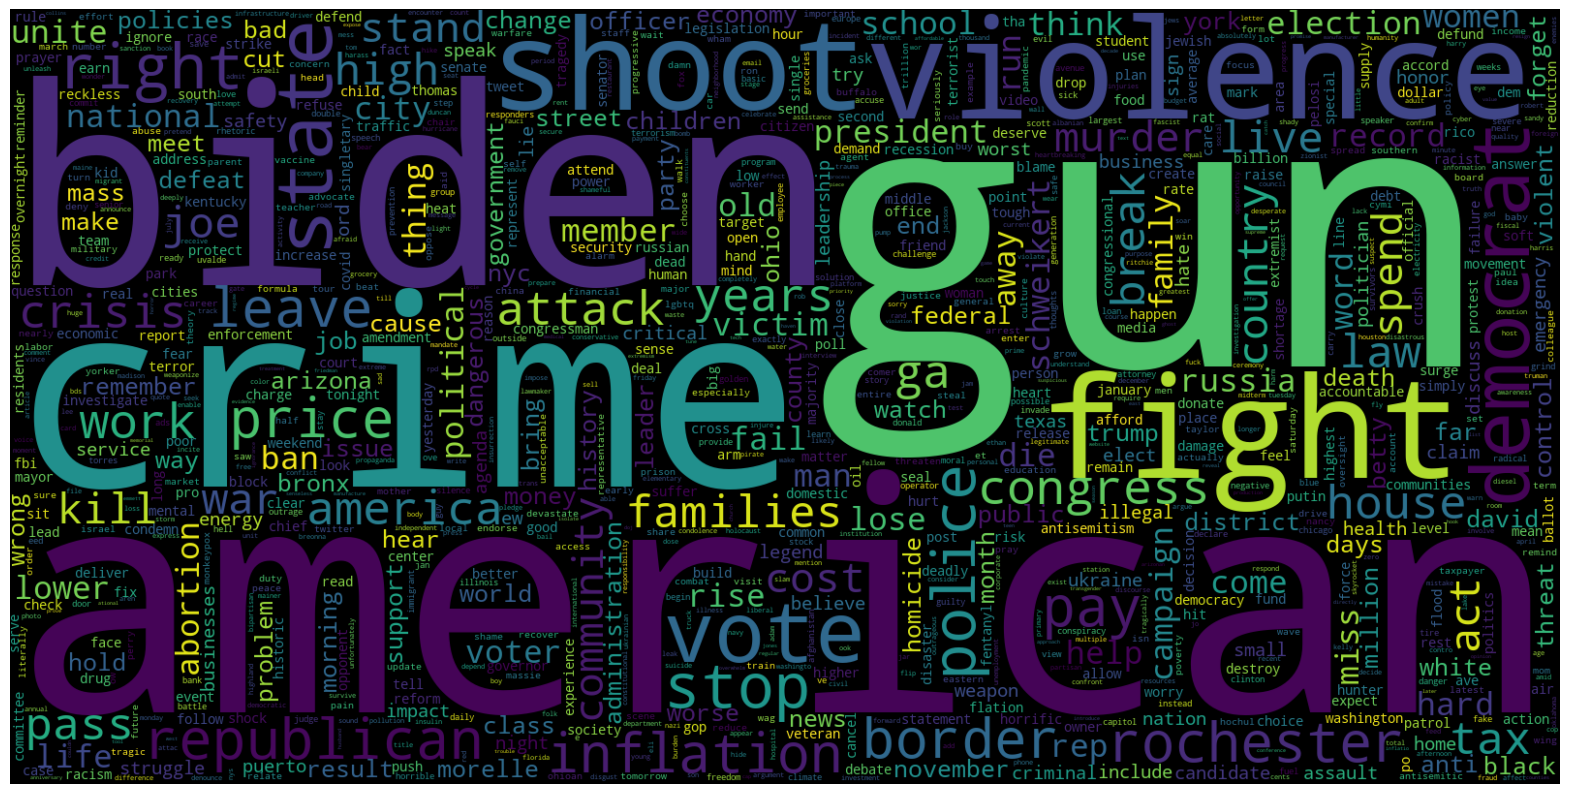

In [14]:
negative =' '.join([i for i in data['processed'][data['Negative'] > data["Positive"]]])
wordcloud = WordCloud(max_words=1000, width=1600, height = 800,
                      stopwords=stop_words, collocations = False).generate(negative)
plt.figure( figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Sentiment analysis using TextBlob

In [16]:
df_LDA = data.copy()

In [34]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

data['subjectivity'] = data['processed'].apply(getSubjectivity)

data["sentiment"] = data.apply(lambda x: "positive" if x["Positive"] > x["Negative"] and x["Positive"] > x["Neutral"] else
                                         ("negative" if x["Negative"] > x["Positive"] and x["Negative"] > x["Neutral"] else
                                          "neutral"), axis=1)
data

processed  Positive  Negative  \
0                              vote early family georgia     0.000       0.0   
1                                          ook boyfriend     0.000       0.0   
2                                              word live     0.000       0.0   
3      welp win count pretty sure friends washington ...     0.756       0.0   
4      energize crowd college park cheer statewide de...     0.478       0.0   
...                                                  ...       ...       ...   
64642                                e look toilet flush     0.000       0.0   
64643       tire win tire omicron country choose wrongly     0.388       0.0   
64644       tire win tire omicron country choose wrongly     0.388       0.0   
64645                                           word tha     0.000       0.0   
64646                                           word tha     0.000       0.0   

       Neutral party sentiment  subjectivity  
0        1.000   DEM   neutral      0.300000  
1        1.000   DEM   neutral      0.000000  
2        1.000   DEM   neutral      0.500000  
3        0.244   DEM  positive      0.762963  
4        0.522   DEM   neutral      0.000000  
...        ...   ...       ...           ...  
64642    1.000   DEM   neutral      0.000000  
64643    0.612   REP   neutral      0.650000  
64644    0.612   DEM   neutral      0.650000  
64645    1.000   REP   neutral      0.000000  
64646    1.000   DEM   neutral      0.000000  

[64647 rows x 7 columns]

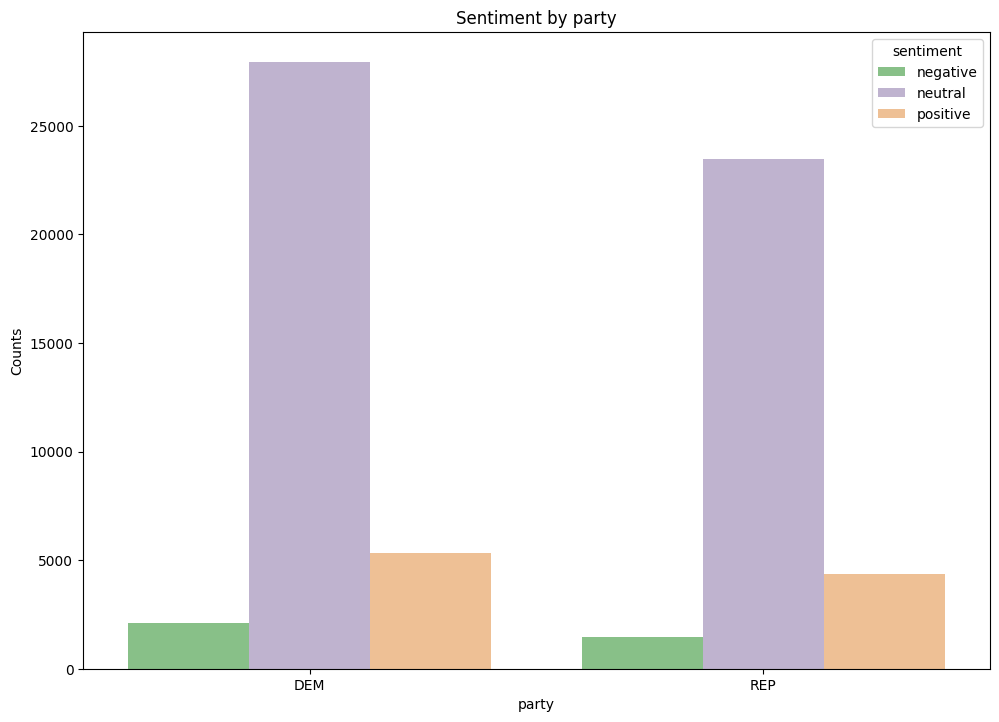

In [36]:
x = data.groupby(['sentiment','party']).size().to_frame('sentiment.value_counts()').reset_index()
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='party', y='sentiment.value_counts()', hue='sentiment', data=x,  palette='Accent').set(title='Sentiment by party')
ax.set(xlabel='party', ylabel='Counts')
plt.show()

### Naive Bayes

In [39]:

#Encoding Labels and Making Train-Test Splits
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

x= data['processed'].values
y = data['sentiment'].values
x, x_test, y, y_test = train_test_split(x,y, stratify=y, test_size=0.25, random_state=42)

# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x = vec.fit_transform(x).toarray()
x_test = vec.transform(x_test).toarray()

#Building the Naive Bayes Classifier
model = MultinomialNB()
model.fit(x, y)
a=model.score(x_test, y_test)
print("Naive Bayes Accuracy score of polarity:",a)

Naive Bayes Accuracy score of polarity: 0.9068184630615023


In [38]:
model.predict(vec.transform(["Polarity is worst"]))

array(['neutral'], dtype='<U8')

### Logistic Regression

In [41]:

from sklearn.linear_model import LogisticRegression


x= data['processed'].values
y = data['sentiment'].values
x, x_test, y, y_test = train_test_split(x,y, stratify=y, test_size=0.4, random_state=101)

# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x = vec.fit_transform(x).toarray()
x_test = vec.transform(x_test).toarray()
classifier= LogisticRegression(random_state=0)  
classifier.fit(x, y)  
b=classifier.score(x_test,y_test)
print("Logistic Regression Accuracy score for polarity:",a)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy score for polarity: 0.9068184630615023


In [44]:
from sklearn.metrics import classification_report

predictions=classifier.predict(x_test)
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

    negative       0.99      0.89      0.93      1427
     neutral       0.98      1.00      0.99     20551
    positive       0.98      0.94      0.96      3881

    accuracy                           0.98     25859
   macro avg       0.98      0.94      0.96     25859
weighted avg       0.98      0.98      0.98     25859



### LDA for topic analysis

In [17]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, # minimum required occurences of a word 
                             min_df=35, # maximum required occurences of a word 
                             max_features=6000,
                             analyzer='word',  
                             ngram_range=(1,2),
                             # stop_words=set(stopwords),# remove stop words
                             token_pattern=r'\w+|\$[\d\.]+|\S+')

dtm = vectorizer.fit_transform(data['processed'])

tf_feature_names = vectorizer.get_feature_names_out()

CPU times: total: 828 ms
Wall time: 881 ms


In [18]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=7, # Number of topics
                                      learning_method='online',
                                      random_state=20,       
                                      n_jobs = -1  # Use all available CPUs
                                      )

lda_topics=lda_model.fit_transform(dtm)

In [19]:
for i in lda_topics[-10:]:
    x = i.argsort().tolist()
    print(i[0])

0.22857164678662967
0.22857164678662967
0.6284971746168533
0.6284971746168533
0.3809531860077016
0.3809531860077016
0.023809524488491378
0.023809524488491378
0.3809522751269623
0.3809522751269623


In [20]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 10
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0 words Topic 0 weights Topic 1 words Topic 1 weights Topic 2 words  \
0          meet          2101.3         honor          2073.9       support   
1          help          1833.1      american          1469.4     community   
2          come          1675.2          ohio          1289.9        police   
3        county          1188.7    republican          1153.6        voters   
4          look           989.3           gas           971.7     rochester   
5       protect           979.4          hear           928.3           tha   
6           joe           956.3         spend           927.0        attend   
7          love           930.8          good           828.1      congress   
8        family           920.2         doors           700.3          host   
9        change           897.4           big           671.5        better   

  Topic 2 weights Topic 3 words Topic 3 weights Topic 4 words Topic 4 weights  \
0          1967.1       america          1518.9          vote          3251.4   
1          1357.1      district          1495.4      campaign          1592.4   
2          1331.6         state          1396.4      election          1403.0   
3          1103.1      congress          1375.2          days          1194.5   
4          1078.6         house          1335.7      november          1010.4   
5          1070.6     democrats          1323.4          team           869.5   
6           973.9         party          1274.5       morning           830.4   
7           900.7         price          1183.8           win           744.8   
8           858.3     candidate          1065.8           law           727.1   
9           814.0     inflation          1003.3         ready           648.3   

  Topic 5 words Topic 5 weights Topic 6 words Topic 6 weights  
0         right          2466.4         biden          1478.7  
1   endorsement          1866.9     president          1424.4  
2       support          1071.4           gun          1353.1  
3         alert          1018.4     americans          1162.0  
4         women           981.7         shoot          1033.8  
5        public           944.7         trump           972.5  
6         break           939.7      violence           954.0  
7          life           919.1         leave           886.2  
8          work           868.4         stand           878.2  
9          news           866.6      national           876.3

In [21]:
## assign topics 
df_LDA['LDA_Topic']=lda_topics.argmax(axis=1)

naming={0:'Economy',
        1:'Russia',
        2:'Covid Relief',
        3:'Legislation',
        4:'Jobs',
        5: 'War',
        6: 'Gun'
        }

df_LDA['LDA_Topic_name']=df_LDA['LDA_Topic'].map(naming)

df_LDA

processed  Positive  Negative  \
0                              vote early family georgia     0.000       0.0   
1                                          ook boyfriend     0.000       0.0   
2                                              word live     0.000       0.0   
3      welp win count pretty sure friends washington ...     0.756       0.0   
4      energize crowd college park cheer statewide de...     0.478       0.0   
...                                                  ...       ...       ...   
64642                                e look toilet flush     0.000       0.0   
64643       tire win tire omicron country choose wrongly     0.388       0.0   
64644       tire win tire omicron country choose wrongly     0.388       0.0   
64645                                           word tha     0.000       0.0   
64646                                           word tha     0.000       0.0   

       Neutral party  Subjectivity  Polarity  LDA_Topic LDA_Topic_name  
0        1.000   DEM      0.300000  0.100000          4           Jobs  
1        1.000   DEM      0.000000  0.000000          4           Jobs  
2        1.000   DEM      0.500000  0.136364          0        Economy  
3        0.244   DEM      0.762963  0.516667          3    Legislation  
4        0.522   DEM      0.000000  0.000000          2   Covid Relief  
...        ...   ...           ...       ...        ...            ...  
64642    1.000   DEM      0.000000 -0.033333          0        Economy  
64643    0.612   REP      0.650000  0.150000          5            War  
64644    0.612   DEM      0.650000  0.150000          5            War  
64645    1.000   REP      0.000000  0.000000          2   Covid Relief  
64646    1.000   DEM      0.000000  0.000000          2   Covid Relief  

[64647 rows x 9 columns]

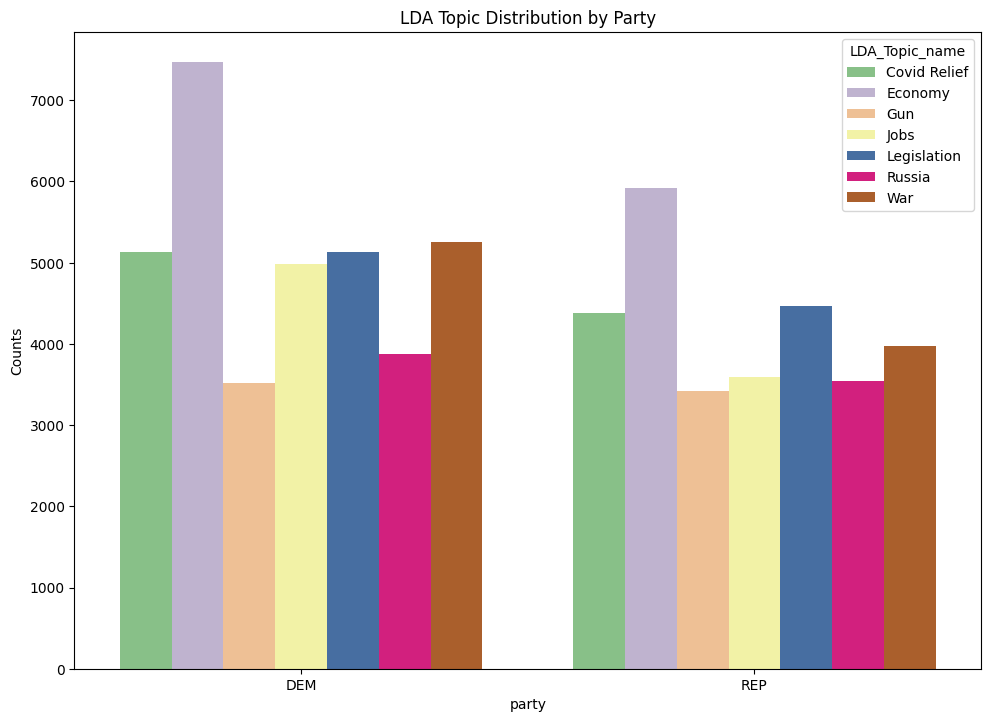

In [22]:
df_LDA.to_csv('data/df_LDA.csv', encoding='UTF-8', index=False)
a4_dims = (11.7, 8.27)

x = df_LDA.groupby(['LDA_Topic_name','party']).size().to_frame('LDA_Topic_name.value_counts()').reset_index()
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='party', y='LDA_Topic_name.value_counts()', hue='LDA_Topic_name', data=x,  palette='Accent').set(title='LDA Topic Distribution by Party')
ax.set(xlabel='party', ylabel='Counts')
plt.show()

In [23]:
df_LDA[df_LDA.party=='REP'].LDA_Topic_name.value_counts()

Economy         5919
Legislation     4461
Covid Relief    4377
War             3978
Jobs            3594
Russia          3543
Gun             3420
Name: LDA_Topic_name, dtype: int64

### N-grams

In [24]:
def get_top_n_gram(corpus,ng_range, ntype, n=None):
    vec = CountVectorizer(ngram_range=ng_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in      vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    ngrams = pd.DataFrame(words_freq[:n],columns = [ntype , 'count'])
    return ngrams

In [25]:
all_bigrams_df  = get_top_n_gram(df_LDA.processed, (2,2),'All Tweet Bigrams',10)
all_trigrams_df = get_top_n_gram(df_LDA.processed, (3,3),'All Tweet Trigrams',10)

GOP_bigrams     = get_top_n_gram(df_LDA[df_LDA.party=='REP'].processed, (2,2),'Republican Bigrams',10)
DEM_bigrams     =  get_top_n_gram(df_LDA[df_LDA.party=='DEM'].processed, (2,2),'Democrat Bigrams',10)

GOP_trigrams    = get_top_n_gram(df_LDA[df_LDA.party=='REP'].processed, (3,3),'Republican Trigrams',10)
DEM_trigrams    =  get_top_n_gram(df_LDA[df_LDA.party=='DEM'].processed, (3,3),'Democrat Trigrams',10)

In [26]:
GOP_trigrams

Republican Trigrams  count
0      woman right choose    150
1  supreme court overturn    129
2          saw break news    126
3      break news supreme    126
4      news supreme court    126
5    court overturn woman    126
6    overturn woman right    126
7        right choose sad    126
8      choose sad history    126
9     sad history america    126

In [27]:
DEM_trigrams

Democrat Trigrams  count
0      woman right choose    174
1  supreme court overturn    132
2          saw break news    126
3      break news supreme    126
4      news supreme court    126
5    court overturn woman    126
6    overturn woman right    126
7        right choose sad    126
8      choose sad history    126
9     sad history america    126

In [28]:
DEM_bigrams


Democrat Bigrams  count
0        david schweikert    393
1           supreme court    288
2       endorsement alert    285
3            gun violence    279
4             unite state    273
5  congressional district    246
6            run congress    219
7               gas price    216
8               stay safe    195
9             joe morelle    192

In [29]:
GOP_bigrams

Republican Bigrams  count
0            hunter biden    285
1               joe biden    255
2               eli crane    255
3       endorsement alert    249
4           supreme court    243
5               gas price    240
6             unite state    222
7         president trump    204
8  congressional district    201
9         president biden    201